<a href="https://colab.research.google.com/github/ReemAlsharabi/GTSRB-CNN/blob/main/GTSRB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
#Prepare all our necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

#pytorch libraries
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Pad, Compose, CenterCrop, ToPILImage, Normalize, ConvertImageDtype, Resize
from torch import nn, optim
from torch.nn import init, Linear, ReLU, Softmax
from torch.nn.init import xavier_uniform_
from torch.optim import SGD, Adam
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import WeightedRandomSampler

import datetime
import cv2
from PIL import Image

from sklearn.utils import compute_class_weight

import torch.optim as opt
import random
from google.colab import drive
import zipfile

import torch.nn.init as init

# random seed

In [ ]:
def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f'Set seed {seed}')

set_seed(42)

Set seed 42


# Dataset

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Set path to zip file on Google Drive
zip_path = '/content/drive/MyDrive/archive.zip'

# Set path to directory where unzipped data will be stored
data_path = '/content/data'

# Unzip data from zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

Mounted at /content/drive


In [ ]:
# Prepare our Dataset Structure, as it has to be normalized for pytorch
class GTSRB(Dataset):
    def __init__(self, annotations_file, img_dir , transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[["Path","ClassId"]]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        label = self.img_labels.iloc[idx, 1]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# transformation & dataloaders

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((30,30)),
    transforms.RandomApply([
        transforms.RandomRotation(20),
        transforms.RandomAffine(0, translate=(0.2, 0.2)),
        transforms.RandomAffine(0, shear=20),
        transforms.RandomAffine(0, scale=(0.8, 1.2))
    ]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1/255, 1/255, 1/255])
])

# creating training dataset
img_dir = data_path
train_file = "/content/data/Train.csv"
train_data = GTSRB(img_dir = img_dir, annotations_file = train_file,
                   transform = data_transforms)
test_file = "/content/data/Test.csv"
test_data = GTSRB(img_dir = img_dir, annotations_file = test_file,
                   transform = data_transforms)
#Prepare DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

# samples visualization

Feature batch shape: torch.Size([32, 3, 30, 30])
Labels batch shape: torch.Size([32])


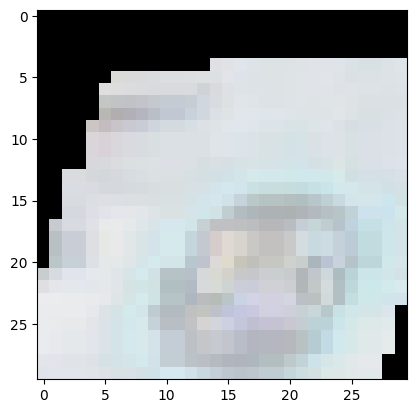

Label: 2


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
test_features, test_labels = next(iter(test_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
img = ToPILImage()(img).convert("RGB")
plt.imshow(img)
plt.show()
print(f"Label: {label}")

# moving data to the GPU

In [ ]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)
train_dataloader = WrappedDataLoader(train_dataloader, to_device)
test_dataloader = WrappedDataLoader(test_dataloader, to_device)

# CNN model

In [ ]:
class conv_net(nn.Module):
    def __init__(self, dropout_prob=0.25):
        super(conv_net,self).__init__()

        self.conv1 = nn.Conv2d(3,32,(3,3), 1, 1)
        init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu') # parameter initialization strategy
        self.dropout_input = nn.Dropout(p=dropout_prob)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,164, (3,3), 1, 1)
        init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu') # parameter initialization strategy
        self.bn2 = nn.BatchNorm2d(164)

        self.conv3 = nn.Conv2d(164,128,(3,3), 1, 1)
        init.kaiming_uniform_(self.conv3.weight, nonlinearity='relu') # parameter initialization strategy
        self.bn3 = nn.BatchNorm2d(128)

        self.linear1 = nn.Linear(128*3*3,512)
        init.kaiming_uniform_(self.linear1.weight, nonlinearity='relu') # parameter initialization strategy
        self.linear2 = nn.Linear(512,256)
        init.kaiming_uniform_(self.linear2.weight, nonlinearity='relu') # parameter initialization strategy
        self.linear3 = nn.Linear(256,43)
        init.kaiming_uniform_(self.linear3.weight, nonlinearity='relu') # parameter initialization strategy

        self.relu = nn.ELU(alpha=1.0)
        self.pool = nn.MaxPool2d((2,2))
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob)

    def forward(self, X):
        if self.training:
            # Apply dropout during training
            X = self.pool(self.relu(self.bn1(self.conv1(X)))) # (30)/2 = 15
            X = self.dropout1(X)
            X = self.pool(self.relu(self.bn2(self.conv2(X)))) # (15)/2 = 7
            X = self.dropout1(X)
            X = self.pool(self.relu(self.bn3(self.conv3(X)))) # (7)/2 = 3

            X = X.view(X.size(0),-1)  # Flatten the tensor
            X = F.relu(self.linear1(X))
            X = self.dropout2(X)
            X = F.relu(self.linear2(X))
            X = self.linear3(X)

        else:
            # Apply Monte Carlo dropout during evaluation
            outputs = []
            for i in range(20):
                X = self.pool(self.relu(self.bn1(self.conv1(X))))
                X = self.pool(self.relu(self.bn2(self.conv2(X))))
                X = self.pool(self.relu(self.bn3(self.conv3(X))))
                X = X.view(X.size(0),-1)
                X = F.relu(self.linear1(X))
                X = F.relu(self.linear2(X))
                X = self.linear3(X)
                outputs.append(X)
            X = torch.stack(outputs).mean(0)

        return X

# plotting the loss

In [ ]:
def plot(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Training utilities

In [ ]:
def clip_gradients_(
    clip_grad_strategy,
    model_fn,
    clip_value=None,
    error_if_nonfinite=False,
    max_norm=None,
    norm_type=2.0):
    if clip_grad_strategy == "value" and clip_value is not None:
        nn.utils.clip_grad_value_(
            model_fn.parameters(),
            clip_value
        )
    elif clip_grad_strategy == "norm" and max_norm is not None:
        nn.utils.clip_grad_norm_(
            model_fn.parameters(),
            max_norm,
            norm_type,
            error_if_nonfinite
        )
    elif clip_grad_strategy is None:
        pass
    else:
        raise NotImplementedError()

# Training loop

In [ ]:
model = conv_net()
# put on cuda if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

lr=0.1
nb_epochs = 100
criterion = nn.CrossEntropyLoss(reduction = "mean") # loss function

# SGD w momentum
optim = opt.SGD(
    model.parameters(),
    lr=lr/10,
    momentum=0.9,
    dampening=0.0,
)


# lr_scheduler = opt.lr_scheduler.ExponentialLR(
#     optim,
#     gamma=0.9
# )

# lr_scheduler = opt.lr_scheduler.StepLR(
#     optim,
#     step_size=5,
#     gamma=0.1,
# )

# lr_scheduler = opt.lr_scheduler.CosineAnnealingLR(optim, T_max=nb_epochs)

lr_scheduler = opt.lr_scheduler.OneCycleLR(
    optim,
    epochs=nb_epochs,
    steps_per_epoch=1, # because we update after each epoch!
    max_lr=lr,
)


# best_val_loss = float('inf')
accuracy = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []
lrs = []

for epoch in range(nb_epochs):
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_dataloader, 0):
        train_features, train_labels = data
        train_features, train_labels = train_features.to(device), train_labels.to(device)

        model.eval()
        model.train()

        optim.zero_grad()

        # forward pass
        prediction = model(train_features).to(torch.float32)
        loss = criterion(prediction, train_labels.to(torch.long))

        # backward pass
        loss.backward()
        clip_gradients_(
                clip_grad_strategy=None,
                model_fn = model,
                clip_value=None,
                error_if_nonfinite=False,
                max_norm=None,
                norm_type=2.0
            )
        optim.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(prediction.data, 1)
        total_train += train_labels.size(0)
        correct_train += (predicted == train_labels).sum().item()

    train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # validation accuracy
    with torch.no_grad():
        for j, test_data in enumerate(test_dataloader, 0):
            test_features, test_labels = test_data
            test_features, test_labels = test_features.to(device), test_labels.to(device)
            test_prediction = model(test_features).to(torch.float32)

            val_loss = criterion(test_prediction, test_labels)
            total_val_loss += val_loss.item()
            _, test_predicted = torch.max(test_prediction.data, 1)
            total_val += test_labels.size(0)
            correct_val += (test_predicted == test_labels).sum().item()
    val_loss = total_val_loss / len(test_dataloader)
    val_losses.append(val_loss)
    val_acc = correct_val / total_val
    val_accs.append(val_acc)

    # update the learning rate after every training epoch
    if lr_scheduler is not None:
        lrs.append(lr_scheduler.get_last_lr()[-1])
        lr_scheduler.step()

    # Save the weights if this is the best epoch so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_weights.pth')

    print(f"Epoch {epoch}, Train Loss {train_loss:.4f}, Train Accuracy {train_acc:.4f}, Val Loss {val_loss:.4f}, Val Accuracy {val_acc:.4f}")

plot(train_losses, val_losses, train_accs, val_accs)

Epoch 0, Train Loss 2.2916, Train Accuracy 0.3272, Val Loss 1.8201, Val Accuracy 0.4348
Epoch 1, Train Loss 1.3113, Train Accuracy 0.5794, Val Loss 1.3231, Val Accuracy 0.5995
Epoch 2, Train Loss 0.8950, Train Accuracy 0.7113, Val Loss 0.9485, Val Accuracy 0.7036
Epoch 3, Train Loss 0.6944, Train Accuracy 0.7740, Val Loss 0.8861, Val Accuracy 0.7246
Epoch 4, Train Loss 0.5827, Train Accuracy 0.8113, Val Loss 0.7369, Val Accuracy 0.7735
Epoch 5, Train Loss 0.5070, Train Accuracy 0.8340, Val Loss 0.7094, Val Accuracy 0.7851
Epoch 6, Train Loss 0.4474, Train Accuracy 0.8536, Val Loss 0.7230, Val Accuracy 0.7831
Epoch 7, Train Loss 0.4196, Train Accuracy 0.8657, Val Loss 0.6391, Val Accuracy 0.8100
Epoch 8, Train Loss 0.3688, Train Accuracy 0.8792, Val Loss 0.6433, Val Accuracy 0.8146
Epoch 9, Train Loss 0.3540, Train Accuracy 0.8858, Val Loss 0.5611, Val Accuracy 0.8337
Epoch 10, Train Loss 0.3282, Train Accuracy 0.8934, Val Loss 0.5599, Val Accuracy 0.8322
Epoch 11, Train Loss 0.3142, Tr

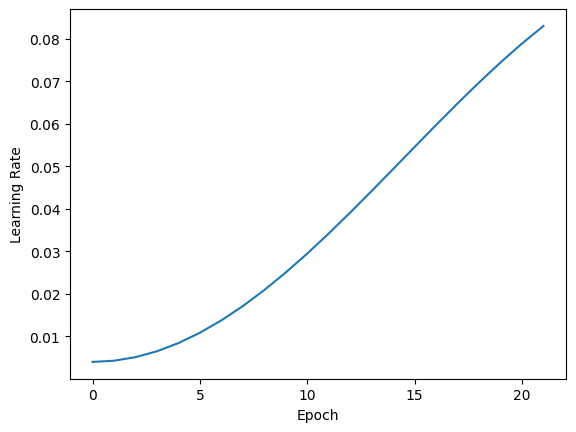

In [ ]:
plt.plot(lrs)
plt.title("lr_scheduler")
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

In [ ]:
type(lr_scheduler)